In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
os.listdir("./data")

['sample_submission_HSqiq1Q.csv', 'test_fjtUOL8.csv', 'train_fNxu4vz.csv']

In [3]:
train = pd.read_csv("./data/train_fNxu4vz.csv")
test = pd.read_csv("./data/test_fjtUOL8.csv")

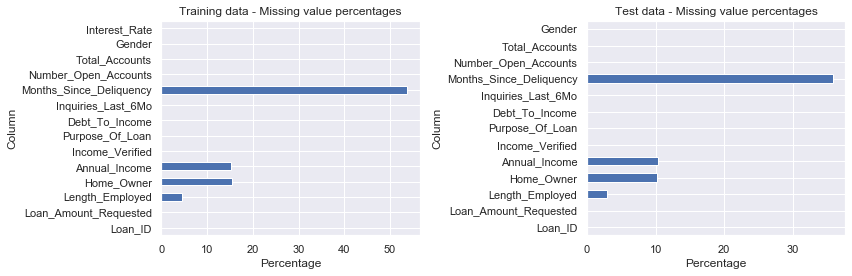

In [4]:
train_miss_perc = (train.isna().sum() / len(train))*100
test_miss_perc = (test.isna().sum() / len(train))*100

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax = train_miss_perc.plot.barh(title="Training data - Missing value percentages")
ax.set_ylabel("Column")
ax.set_xlabel("Percentage")
ax1 = fig.add_subplot(122)
ax1 = test_miss_perc.plot.barh(title="Test data - Missing value percentages")
ax1.set_ylabel("Column")
ax1.set_xlabel("Percentage")
fig.tight_layout()
plt.show()

In [5]:
def preprocess_data(train, test):
    
    # Make Loan amount into float
    train["Loan_Amount_Requested"] = train["Loan_Amount_Requested"].apply(lambda x : float(x.replace(',', '')))
    test["Loan_Amount_Requested"] = test["Loan_Amount_Requested"].apply(lambda x : float(x.replace(',', '')))

    # Fill deliquency missin values with '0' [Assuming there is no deliquency committed]
    train["Months_Since_Deliquency"] = train["Months_Since_Deliquency"].fillna(0)
    test["Months_Since_Deliquency"] = test["Months_Since_Deliquency"].fillna(0)

    # Replace missing income values with median value [Median of train data]
    income_median = train.Annual_Income.median()
    train["Annual_Income"] = train["Annual_Income"].fillna(income_median)
    test["Annual_Income"] = test["Annual_Income"].fillna(income_median)

    # Replace missing values in Home owner with most frequent in training data
    homeowner_most_freq = train.Home_Owner.value_counts().index[0]
    train["Home_Owner"] = train["Home_Owner"].fillna(homeowner_most_freq)
    test["Home_Owner"] = test["Home_Owner"].fillna(homeowner_most_freq)

    # Replace missing values in length employed with most frequent in training data
    length_employed_most_freq = train.Length_Employed.value_counts().index[0]
    train["Length_Employed"] = train["Length_Employed"].fillna(length_employed_most_freq)
    test["Length_Employed"] = test["Length_Employed"].fillna(length_employed_most_freq)

    # Change target column to categorical
    train.Interest_Rate = train.Interest_Rate.astype("category")
    
    return train, test

train, test = preprocess_data(train, test)

In [6]:
train.shape, test.shape

((164309, 14), (109541, 13))

In [7]:
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,7000.0,< 1 year,Rent,68000.0,not verified,car,18.37,0,0.0,9,14,Female,1
1,10000002,30000.0,4 years,Mortgage,63000.0,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,24725.0,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,0.0,12,16,Male,3
3,10000004,16000.0,< 1 year,Mortgage,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,0.0,16,22,Male,3
4,10000005,17000.0,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,0.0,19,30,Female,1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Loan_ID                  164309 non-null  int64   
 1   Loan_Amount_Requested    164309 non-null  float64 
 2   Length_Employed          164309 non-null  object  
 3   Home_Owner               164309 non-null  object  
 4   Annual_Income            164309 non-null  float64 
 5   Income_Verified          164309 non-null  object  
 6   Purpose_Of_Loan          164309 non-null  object  
 7   Debt_To_Income           164309 non-null  float64 
 8   Inquiries_Last_6Mo       164309 non-null  int64   
 9   Months_Since_Deliquency  164309 non-null  float64 
 10  Number_Open_Accounts     164309 non-null  int64   
 11  Total_Accounts           164309 non-null  int64   
 12  Gender                   164309 non-null  object  
 13  Interest_Rate            164309 non-null  ca

In [9]:
train.describe()

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts
count,1.643090e+05,164309.00000,1.643090e+05,164309.000000,164309.000000,164309.000000,164309.000000,164309.000000
mean,1.008216e+07,14349.33692,7.175284e+04,17.207189,0.781698,15.817971,11.193818,25.067665
std,4.743207e+04,8281.86870,5.569855e+04,7.845083,1.034747,22.584642,4.991813,11.583067
min,1.000000e+07,500.00000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000
25%,1.004108e+07,8000.00000,4.860000e+04,11.370000,0.000000,0.000000,8.000000,17.000000
50%,1.008216e+07,12075.00000,6.300000e+04,16.840000,0.000000,0.000000,10.000000,23.000000
75%,1.012323e+07,20000.00000,8.200000e+04,22.780000,1.000000,28.000000,14.000000,32.000000
max,1.016431e+07,35000.00000,7.500000e+06,39.990000,8.000000,180.000000,76.000000,156.000000


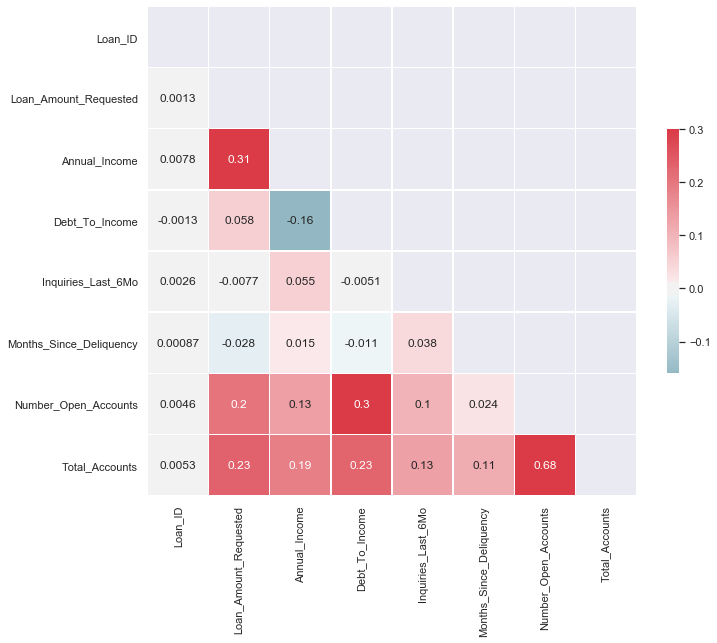

In [10]:
corr = train.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

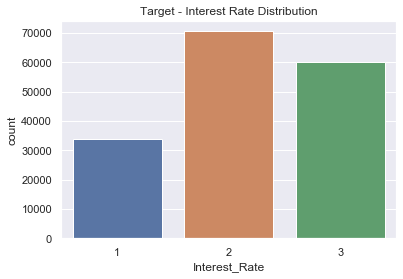

In [11]:
sns.countplot(train.Interest_Rate)
plt.title("Target - Interest Rate Distribution")
plt.show()

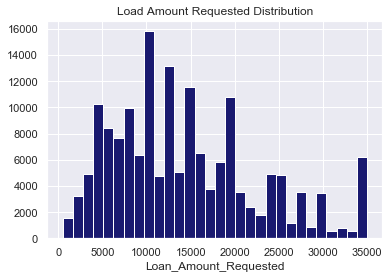

In [12]:
sns.distplot(train["Loan_Amount_Requested"], kde=False, bins=30, color="midnightblue", 
             hist_kws={"alpha": 1})
plt.title("Load Amount Requested Distribution")
plt.show()

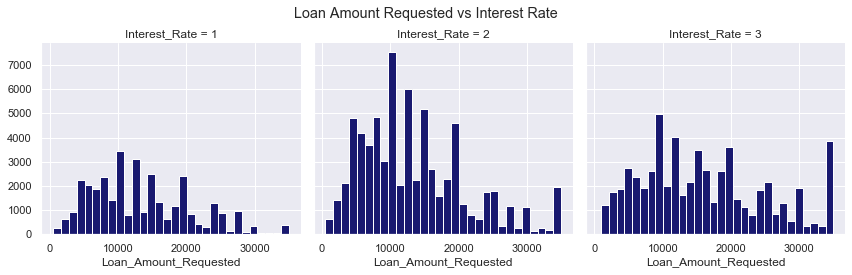

In [13]:
g = sns.FacetGrid(train, col="Interest_Rate", height=4)
g = g.map(sns.distplot, "Loan_Amount_Requested", kde=False, bins=30, color="midnightblue", 
             hist_kws={"alpha": 1})
plt.suptitle("Loan Amount Requested vs Interest Rate")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

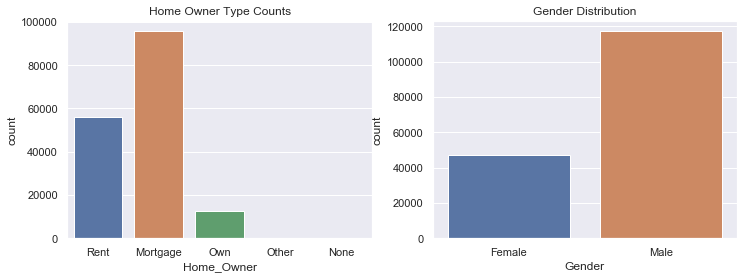

In [14]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(121)
ax = sns.countplot(train["Home_Owner"], ax=ax)
ax.set_title("Home Owner Type Counts")

ax = fig.add_subplot(122)
ax = sns.countplot(train["Gender"], ax=ax)
ax.set_title("Gender Distribution")
plt.show()

D:\Users\prana\Anaconda3\envs\Python3.7\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


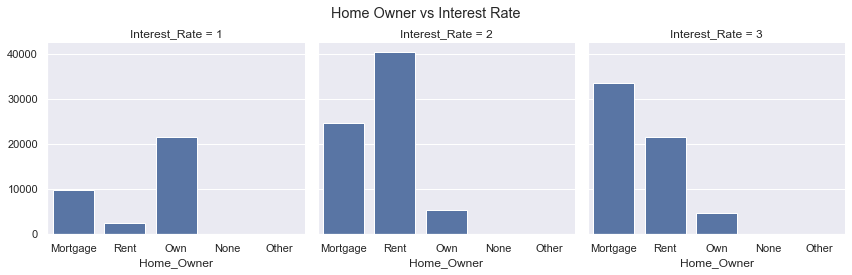

In [15]:
g = sns.FacetGrid(train, col="Interest_Rate", height=4)
g = g.map(sns.countplot, "Home_Owner")
plt.suptitle("Home Owner vs Interest Rate")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

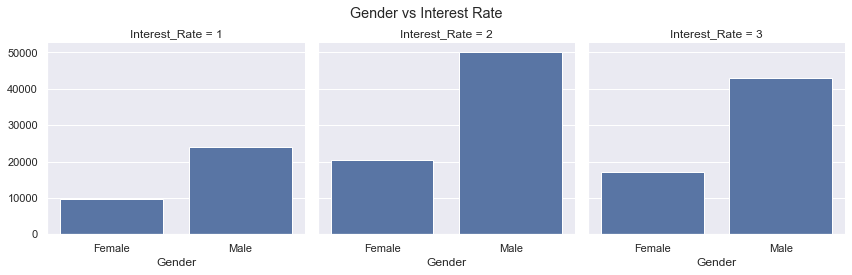

In [16]:
g = sns.FacetGrid(train, col="Interest_Rate", height=4)
g = g.map(sns.countplot, "Gender")
plt.suptitle("Gender vs Interest Rate")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

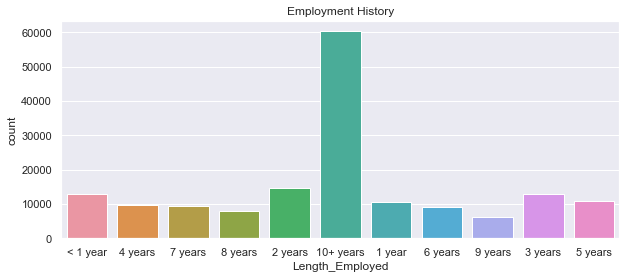

In [17]:
plt.figure(figsize=(10,4))
sns.countplot(train["Length_Employed"])
plt.title("Employment History")
plt.show()

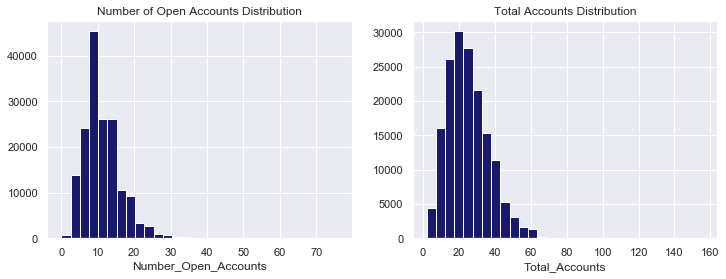

In [18]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(121)
ax = sns.distplot(train["Number_Open_Accounts"], kde=False, bins=30, color="midnightblue", 
             hist_kws={"alpha": 1}, ax=ax)
ax.set_title("Number of Open Accounts Distribution")

ax = fig.add_subplot(122)
ax = sns.distplot(train["Total_Accounts"], kde=False, bins=30, color="midnightblue", 
             hist_kws={"alpha": 1}, ax=ax)
ax.set_title("Total Accounts Distribution")
plt.show()

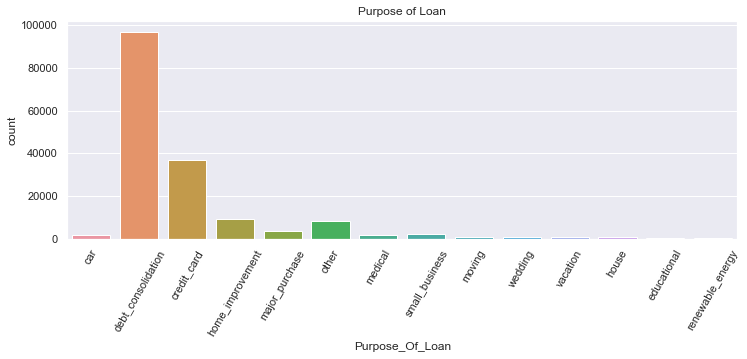

In [19]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(111)
ax = sns.countplot(train["Purpose_Of_Loan"], ax=ax)
ax.set_title("Purpose of Loan")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.show()

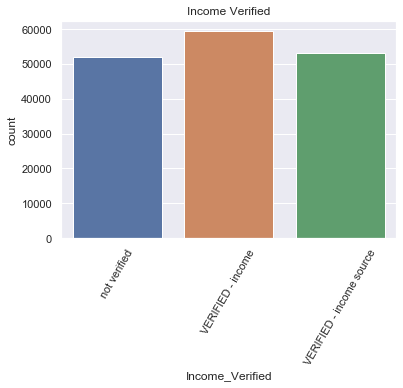

In [20]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)
ax = sns.countplot(train["Income_Verified"], ax=ax)
ax.set_title("Income Verified")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.show()

In [21]:
test.Length_Employed.unique()

array(['10+ years', '< 1 year', '6 years', '8 years', '1 year', '3 years',
       '2 years', '4 years', '7 years', '5 years', '9 years'],
      dtype=object)

In [22]:
train.Length_Employed.unique()

array(['< 1 year', '4 years', '7 years', '8 years', '2 years',
       '10+ years', '1 year', '6 years', '9 years', '3 years', '5 years'],
      dtype=object)

In [23]:
test.Purpose_Of_Loan.unique()

array(['debt_consolidation', 'credit_card', 'home_improvement', 'other',
       'small_business', 'vacation', 'wedding', 'major_purchase', 'car',
       'house', 'medical', 'renewable_energy', 'moving', 'educational'],
      dtype=object)

In [24]:
train.Purpose_Of_Loan.unique()

array(['car', 'debt_consolidation', 'credit_card', 'home_improvement',
       'major_purchase', 'other', 'medical', 'small_business', 'moving',
       'wedding', 'vacation', 'house', 'educational', 'renewable_energy'],
      dtype=object)

# Feature Engineering

## Length_Employed


In [25]:
train.Length_Employed.unique()

array(['< 1 year', '4 years', '7 years', '8 years', '2 years',
       '10+ years', '1 year', '6 years', '9 years', '3 years', '5 years'],
      dtype=object)

In [26]:
def make_length_employed_coarse(val):
    if val in ['< 1 year']:
        return "fresher"
    elif val in ['1 year', '2 years', '3 years', '4 years']:
        return "less_experienced"
    elif val in ['5 years', '6 years', '7 years', '8 years', '9 years']:
        return "more_experienced"
    elif val in ['10+ years']:
        return "most_experienced" 

In [27]:

train["Length_Employed_coarse"] = train["Length_Employed"].apply(make_length_employed_coarse)
test["Length_Employed_coarse"] = test["Length_Employed"].apply(make_length_employed_coarse)

In [28]:
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Length_Employed_coarse
0,10000001,7000.0,< 1 year,Rent,68000.0,not verified,car,18.37,0,0.0,9,14,Female,1,fresher
1,10000002,30000.0,4 years,Mortgage,63000.0,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3,less_experienced
2,10000003,24725.0,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,0.0,12,16,Male,3,more_experienced
3,10000004,16000.0,< 1 year,Mortgage,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,0.0,16,22,Male,3,fresher
4,10000005,17000.0,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,0.0,19,30,Female,1,more_experienced


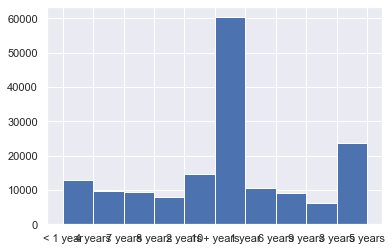

In [29]:
train.Length_Employed.hist()

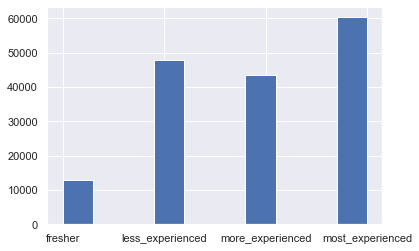

In [30]:
train.Length_Employed_coarse.hist()

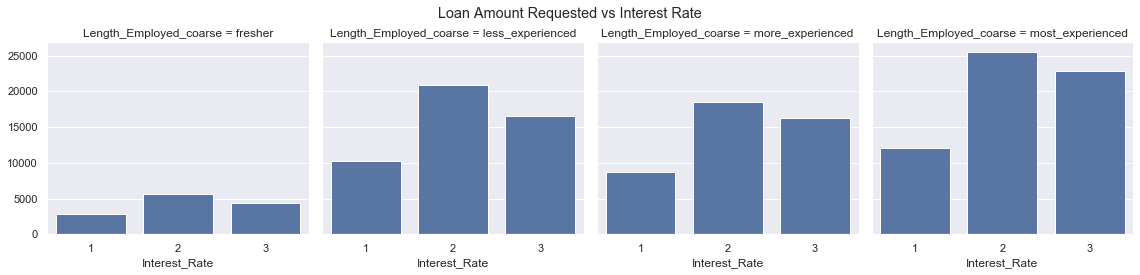

In [51]:
g = sns.FacetGrid(train, col="Length_Employed_coarse", height=4)
g = g.map(sns.countplot, "Interest_Rate")
plt.suptitle("Loan Amount Requested vs Interest Rate")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Home_Owner

In [31]:
train.Home_Owner.unique()

array(['Rent', 'Mortgage', 'Own', 'Other', 'None'], dtype=object)

In [32]:
train.Home_Owner.value_counts()

Mortgage    95694
Rent        56031
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64

In [33]:
def make_home_owner_coarse(val):
    if val in ['Other', 'None']:
        return "Mortgage"
    else:
        return val

In [34]:
train["Home_Owner_coarse"] = train["Home_Owner"].apply(make_home_owner_coarse)
test["Home_Owner_coarse"] = test["Home_Owner"].apply(make_home_owner_coarse)

## Purpose_Of_Loan

In [35]:
train.Purpose_Of_Loan.unique()

array(['car', 'debt_consolidation', 'credit_card', 'home_improvement',
       'major_purchase', 'other', 'medical', 'small_business', 'moving',
       'wedding', 'vacation', 'house', 'educational', 'renewable_energy'],
      dtype=object)

In [36]:
train.Purpose_Of_Loan.value_counts()

debt_consolidation    97101
credit_card           36684
home_improvement       9269
other                  8346
major_purchase         3435
small_business         2392
car                    1885
medical                1541
moving                  974
vacation                837
wedding                 828
house                   773
renewable_energy        123
educational             121
Name: Purpose_Of_Loan, dtype: int64

In [37]:
def make_loan_purpose_coarse(val):
    if val in ['debt_consolidation', 'credit_card', 'other']:
        return val
    elif val in ['car', 'medical', 'house', 'moving', 'wedding', 'educational', 'vacation', 'home_improvement']:
        return "personal"
    elif val in ['major_purchase', 'small_business', 'renewable_energy']:
        return "business"

In [38]:
train["Purpose_Of_Loan_coarse"] = train["Purpose_Of_Loan"].apply(make_loan_purpose_coarse)
test["Purpose_Of_Loan_coarse"] = test["Purpose_Of_Loan"].apply(make_loan_purpose_coarse)

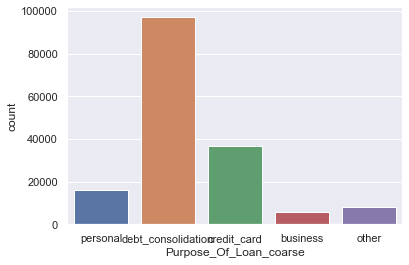

In [39]:
sns.countplot(train.Purpose_Of_Loan_coarse)

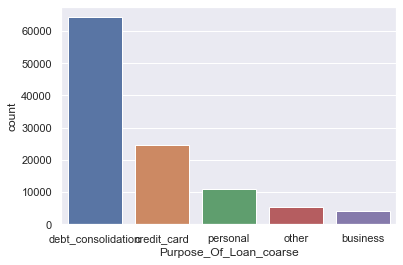

In [40]:
sns.countplot(test.Purpose_Of_Loan_coarse)

In [41]:
train.Purpose_Of_Loan_coarse.unique()

array(['personal', 'debt_consolidation', 'credit_card', 'business',
       'other'], dtype=object)

In [42]:
train.shape

(164309, 17)

In [43]:
test.shape

(109541, 16)

In [44]:
X_train = train.drop(["Loan_ID","Interest_Rate"], axis=1)

In [45]:
X_train = pd.get_dummies(X_train, drop_first=True)

In [46]:
X_train.head()

,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Length_Employed_10+ years,Length_Employed_2 years,Length_Employed_3 years,...,Gender_Male,Length_Employed_coarse_less_experienced,Length_Employed_coarse_more_experienced,Length_Employed_coarse_most_experienced,Home_Owner_coarse_Own,Home_Owner_coarse_Rent,Purpose_Of_Loan_coarse_credit_card,Purpose_Of_Loan_coarse_debt_consolidation,Purpose_Of_Loan_coarse_other,Purpose_Of_Loan_coarse_personal
0,7000.0,68000.0,18.37,0,0.0,9,14,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,30000.0,63000.0,14.93,0,17.0,12,24,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,24725.0,75566.4,15.88,0,0.0,12,16,0,0,0,...,1,0,1,0,0,0,0,1,0,0
3,16000.0,56160.0,14.34,3,0.0,16,22,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,17000.0,96000.0,22.17,1,0.0,19,30,0,0,0,...,0,0,1,0,1,0,0,1,0,0
